In [1]:
import polars as pl

In [2]:
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth , Birch
import numpy as np
import scipy.sparse as sp
import igraph as ig
import leidenalg as la
from collections import Counter
from sklearn.metrics import adjusted_rand_score, rand_score,normalized_mutual_info_score
import networkx as nx
import community as community_louvain
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import community as community_louvain  

In [3]:
df = pl.read_csv("reddit-users.csv")
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.01879

In [6]:
usernames = df["rotoreuters"].to_list()
X = df.drop("rotoreuters")
X

-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,0.43415,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,0.429774,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,0.072753,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,0.261157,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,0.149472,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.096242,0.79333,0.656905,-0.1

In [8]:
from scipy.sparse import csr_matrix

In [24]:
k = 2

nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)

In [25]:
rows = np.repeat(np.arange(len(X)), k)
cols = indices.flatten()
vals = 1 - distances.flatten()        # تبدیل distance → similarity

A = sp.csr_matrix((vals, (rows, cols)), shape=(len(X), len(X)))
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 236760 stored elements and shape (118380, 118380)>

In [27]:
print("نوع داده:", type(A))
print("شکل ماتریس:", A.shape)
print("تعداد عناصر غیر صفر:", A.nnz)
print("تراکم (density):", A.nnz / (A.shape[0] * A.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 236760
تراکم (density): 1.68947457340767e-05


### ماتریس رو متقارن میکنیم 

In [33]:
symmetric_matrix = A.maximum(A.T)
symmetric_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 349034 stored elements and shape (118380, 118380)>

In [34]:
print("نوع داده:", type(symmetric_matrix))
print("شکل ماتریس:", symmetric_matrix.shape)
print("تعداد عناصر غیر صفر:", symmetric_matrix.nnz)
print("تراکم (density):", symmetric_matrix.nnz / (symmetric_matrix.shape[0] * symmetric_matrix.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 349034
تراکم (density): 2.4906405991500792e-05


In [35]:
import community.community_louvain as community_louvain

In [37]:
G = nx.Graph()
rows, cols = symmetric_matrix.nonzero()
for i, j in zip(rows, cols):
    if i < j:  # فقط یک سمت برای گراف غیرجهتی
        G.add_edge(i, j, weight=symmetric_matrix[i, j])
partition = community_louvain.best_partition(G, weight='weight')
(partition)

{np.int32(0): 0,
 np.int32(3): 0,
 np.int32(1): 1,
 np.int32(8526): 1,
 np.int32(109679): 1,
 np.int32(2): 2,
 np.int32(192): 2,
 np.int32(13): 0,
 np.int32(19): 0,
 np.int32(34): 0,
 np.int32(35): 0,
 np.int32(42): 0,
 np.int32(43): 0,
 np.int32(68): 0,
 np.int32(71): 0,
 np.int32(75): 0,
 np.int32(77): 0,
 np.int32(92): 0,
 np.int32(101): 0,
 np.int32(105): 0,
 np.int32(114): 0,
 np.int32(129): 0,
 np.int32(152): 0,
 np.int32(154): 0,
 np.int32(163): 0,
 np.int32(180): 0,
 np.int32(182): 0,
 np.int32(203): 0,
 np.int32(215): 0,
 np.int32(221): 0,
 np.int32(231): 0,
 np.int32(254): 0,
 np.int32(313): 0,
 np.int32(335): 0,
 np.int32(357): 0,
 np.int32(425): 0,
 np.int32(435): 0,
 np.int32(449): 0,
 np.int32(534): 0,
 np.int32(598): 0,
 np.int32(725): 0,
 np.int32(757): 0,
 np.int32(763): 0,
 np.int32(835): 0,
 np.int32(911): 0,
 np.int32(1022): 0,
 np.int32(1262): 0,
 np.int32(1322): 0,
 np.int32(1754): 0,
 np.int32(1838): 0,
 np.int32(2853): 0,
 np.int32(2914): 0,
 np.int32(2924): 0,


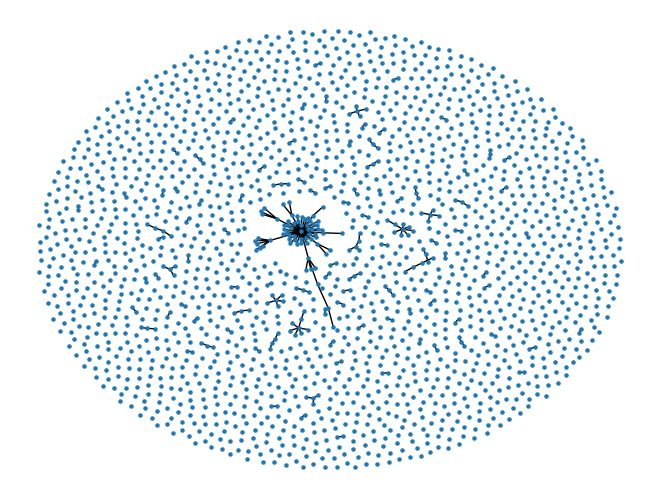

In [45]:
#رسم گراف
sample = list(range(2000))
H = G.subgraph(sample)

nx.draw(H, node_size=5)

In [38]:
from networkx.algorithms.community.quality import modularity

In [39]:
class EvaluationMetrics:
    def __init__(self, graph=None, partition=None):
        """
        graph: NetworkX Graph
        partition: dictionary {node: community_id}
        """
        self.graph = graph
        self.partition = partition

        # metrics
        self.y_true = None
        self.y_pred = None

        self._purity = None
        self._nmi = None
        self._ari = None
        self._ri = None
        self._modularity = None

    # Purity
    def _compute_purity(self):
        y_true = np.asarray(self.y_true)
        y_pred = np.asarray(self.y_pred)

        clusters = np.unique(y_pred)
        N = len(y_true)
        total = 0

        for c in clusters:
            idx = np.where(y_pred == c)[0]
            true_labels = y_true[idx]
            if len(true_labels) == 0:
                continue
            most_common = Counter(true_labels).most_common(1)[0][1]
            total += most_common

        return total / N

    # MAIN FIT
    def fit(self, y_true, y_pred):
        """
        y_true, y_pred should be 1D arrays
        """
        self.y_true = np.asarray(list(y_true))
        self.y_pred = np.asarray(list(y_pred))

        # purity
        self._purity = self._compute_purity()

        # nmi
        self._nmi = normalized_mutual_info_score(self.y_true, self.y_pred)

        # ari
        self._ari = adjusted_rand_score(self.y_true, self.y_pred)

        # ri
        self._ri = rand_score(self.y_true, self.y_pred)

        # modularity (NetworkX)
        if self.graph is not None and self.partition is not None:
            # partition must be list of sets
            communities = {}
            for node, com in self.partition.items():
                communities.setdefault(com, set()).add(node)
            community_list = list(communities.values())

            try:
                self._modularity = modularity(self.graph, community_list, weight="weight")
            except:
                self._modularity = None

        return self

    # GETTERS
    def score_purity(self):
        return self._purity

    def score_nmi(self):
        return self._nmi

    def score_ari(self):
        return self._ari

    def score_ri(self):
        return self._ri

    def score_modularity(self):
        return self._modularity

In [40]:
x = partition.values()
x

dict_values([0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 0, 0, 0, 13, 13, 14, 14, 14, 15, 15, 16, 16, 14, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 29, 29, 563, 563, 31, 31, 24, 24, 32, 32, 0, 0, 0, 0, 0, 0, 0, 33, 33, 21, 21, 2, 0, 34, 34, 35, 35, 10, 10, 36, 36, 31, 31, 37, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 15, 42, 42, 43, 43, 43, 43, 44, 44, 2, 2, 45, 45, 46, 46, 47, 47, 48, 48, 0, 9, 9, 49, 49, 49, 50, 50, 51, 51, 52, 52, 0, 53, 53, 0, 0, 23, 54, 54, 54, 7, 55, 55, 55, 8, 56, 56, 57, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 21, 21, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79, 37, 80, 80, 81, 81, 82, 8

In [41]:
metrics = EvaluationMetrics(graph=G, partition=partition)
x = list(partition.values())
metrics.fit(x,x)

print("Purity:", metrics.score_purity())
print("NMI:", metrics.score_nmi())
print("ARI:", metrics.score_ari())
print("RI:", metrics.score_ri())
print("Modularity:", round(metrics.score_modularity(),3))

Purity: 1.0
NMI: 1.0
ARI: 1.0
RI: 1.0
Modularity: 0.998


### معیار های درست 

In [42]:
class CommunityMetrics:
    def __init__(self, graph, partition):
        """
        graph: networkx.Graph
        partition: dict {node: community_id} یا list[list(nodes)]
        """
        self.graph = graph
        
        # اگر partition دیکشنری است، آن را به لیست لیست تبدیل می‌کنیم
        if isinstance(partition, dict):
            communities = {}
            for node, c in partition.items():
                communities.setdefault(c, []).append(node)
            self.communities = list(communities.values())
        else:
            self.communities = partition

    # 1. Modularity (Newman)
    def modularity(self):
        return nx.algorithms.community.quality.modularity(self.graph, self.communities, weight='weight')

    # 2. Conductance
    def conductance(self):
        conductances = []
        for community in self.communities:
            cut_size = nx.algorithms.cut_size(self.graph, community, weight='weight')
            volume = sum([self.graph.degree(n, weight='weight') for n in community])
            if volume == 0:
                continue
            conductances.append(cut_size / volume)
        return np.mean(conductances)

    # 3. Cut Ratio
    def cut_ratio(self):
        n = self.graph.number_of_nodes()
        m = self.graph.number_of_edges()
        total_cut = 0
        for community in self.communities:
            cut_edges = nx.algorithms.cut_size(self.graph, community, weight='weight')
            total_cut += cut_edges
        if n*(n-1)/2 == 0:
            return 0
        return total_cut / (n*(n-1)/2)

    # 4. Expansion
    def expansion(self):
        expansions = []
        for community in self.communities:
            cut_edges = nx.algorithms.cut_size(self.graph, community, weight='weight')
            expansions.append(cut_edges / len(community))
        return np.mean(expansions)

    # 5. Flake-ODF
    def flake_odf(self):
        flakes = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                if self.graph.degree(node) > 0:
                    if out_edges > self.graph.degree(node)/2:
                        flakes.append(1)
                    else:
                        flakes.append(0)
        if len(flakes) == 0:
            return 0
        return np.mean(flakes)

    # 6. Average Out-Degree Fraction (AODF)
    def aodf(self):
        fractions = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                deg = self.graph.degree(node)
                if deg > 0:
                    fractions.append(out_edges / deg)
        if len(fractions) == 0:
            return 0
        return np.mean(fractions)

    # 7. Modularity Density (Densely connected communities)
    def modularity_density(self):
        total = 0
        m = self.graph.number_of_edges()
        for community in self.communities:
            subgraph = self.graph.subgraph(community)
            lc = subgraph.number_of_edges()
            dc = len(community)*(len(community)-1)/2
            if dc > 0:
                total += lc/dc
        return total / len(self.communities)

In [44]:
metrics = CommunityMetrics(G, partition)

print("Modularity:", round(metrics.modularity(),3))
print("Conductance:", round(metrics.conductance(),3))
print("Cut Ratio:", round(metrics.cut_ratio(),4))
print("Expansion:", round(metrics.expansion(),3))
print("Flake ODF:", (metrics.flake_odf()))
print("AODF:", round(metrics.aodf(),3))
print("Modularity Density:", round(metrics.modularity_density(),3))

Modularity: 0.998
Conductance: 0.0
Cut Ratio: 0.0
Expansion: 0.0
Flake ODF: 0.0
AODF: 0.0
Modularity Density: 0.349


Modularity (0.998) یعنی اجتماع‌ها خیلی خوب از هم جدا شده‌اند و یال‌های زیادی داخل اجتماع‌ها هستند، ولی بین اجتماع‌ها یال کمی وجود دارد

Conductance (0.0) رسانایی صفر یعنی هیچ یالی بین اجتماع‌ها وجود ندارد. پس اجتماع‌ها کاملاً جدا هستند.

Cut Ratio (0.0) نسبت یال‌های بریده‌شده (بین اجتماع‌ها) به کل یال‌ها صفر است → هیچ ارتباطی بین اجتماع‌ها نیست.

Expansion (0.0) توسعه صفر یعنی هیچ یالی از اجتماع‌ها به بیرون نمی‌رود. اجتماع‌ها کاملاً بسته‌اند.

Flake ODF (0.0) این معیار بررسی می‌کند آیا رأس‌ها بیشتر به بیرون وصل‌اند یا داخل اجتماع خودشان. صفر یعنی همه رأس‌ها فقط به اجتماع خودشان وصل‌اند.

AODF (0.0) میانگین Flake ODF هم صفر است → هیچ رأس ارتباط بیرونی ندارد.

Modularity Density (0.349) این معیار نسخه‌ی اصلاح‌شده‌ی modularity است که تراکم داخلی اجتماع‌ها را هم در نظر می‌گیرد. مقدار متوسط (۰.۳۴۹) نشان می‌دهد اجتماع‌ها تراکم داخلی قابل‌قبولی دارند.